In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, gammainc
from scipy.fftpack import fftn, fftshift
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [3]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [4]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

In [5]:
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]
dk = 2*np.pi/(dx*min(wamos.shape[0], wamos.shape[1]))
dk

0.01269330365086785

In [6]:
eta = np.transpose(wamos, (1, 2, 0))
eta.shape

(132, 132, 366)

In [7]:
Nx, Ny, Nt = eta.shape
    
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) 
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) 
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0] 

Norm = dKx * dKy * dW

# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [8]:
def plot_3d_as_2d(x, y, z, radial_filter=False, extent=None, ax=None, aspect='auto', colorbar=True, cb_label='', data_min=None, data_max=None, cmap='viridis'):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    if radial_filter:
        filt = get_radial_filter(x, y)
    else:
        filt = 1
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
    sh = ax.imshow((filt*z).T, origin='lower', extent=(x[0]-dx//2, x[-1]+dx//2, y[0]-dy//2, y[-1]+dy//2 ), aspect=aspect, interpolation=None, vmin=data_min, vmax=data_max, cmap=cmap)
    if colorbar:
        bar = plt.colorbar(sh, ax=ax, label=cb_label)
    if not extent is None:
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
    return ax

In [9]:
def plot_kx_ky_spec(kx, ky, spec, radial_filter=False, extent=None, ax=None, colorbar=True, spec_min=None, spec_max=None, cmap='viridis'):    
    if not spec_min is None:
        data = np.where(spec<spec_min, spec_min, spec)
    if not spec_max is None:
        data = np.where(spec>spec_max, spec_max, spec)
    ax = plot_3d_as_2d(kx, ky, spec, radial_filter, extent, ax, aspect=1, colorbar=colorbar, data_min=spec_min, data_max=spec_max, cmap=cmap)
    ax.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
    return ax

In [10]:
def plot_w_slice(at_w, extent, ax=None, dB=None, vmin=None, save=False):
        '''
        plots the integrated kx-ky-spectrum and the integrated k-omega-spectrum
        '''
        if at_w > 0:
            i = np.argmin(np.abs(w[Nt//2:]-at_w))
            print(at_w, w[Nt//2+i], i) 
            plotting_interface.plot_kx_ky_spec(Kx, Ky, power_Spectrum[:,:,Nt//2+i], extent=extent, ax=ax)
        else:
            i = np.argmin(np.abs(w[:Nt//2]-at_w))
            print(at_w, w[i], i) 
            plotting_interface.plot_kx_ky_spec(Kx, Ky, power_Spectrum[:,:,Nt//2+i], extent=extent, ax=ax)

In [31]:
at_w = 0.8
i = np.argmin(np.abs(w[Nt//2:]-at_w))

In [32]:
# Flatten the array and get the indices of the sorted values
flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]

# Take the top 20 indices
top_20_indices = flat_indices[:50]

# Convert flat indices to 2D indices
top_20_indices_2d = np.unravel_index(top_20_indices, power_Spectrum[:,:,Nt//2+i].shape)

kx_ind, ky_ind = top_20_indices_2d[0], top_20_indices_2d[1]

0.8 0.8006578727045026 115


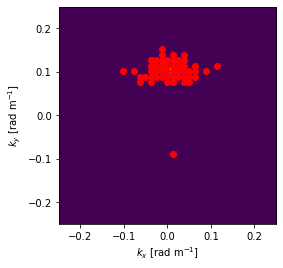

In [33]:
plot_w_slice(at_w, extent = [-0.25,0.25, -0.25, 0.25], ax=None, dB=None, vmin=None, save=False)

plt.scatter(Kx[kx_ind], Ky[ky_ind], color = 'red')

In [50]:
def felip(x, a, b):
    return np.sqrt(b**2 * (1-x**2/b**2))

In [51]:
def fit_elipse(at_w):
    '''Slices the Spectrum at_w and then fits an ellise to the points

    Input : at_w  location of the omgea slice (positive)
    
    Output : x_values  ellipse fitting x vals
             y_values  ellipse fitting y vals'''
    
    ## Find the rough Triplet value points 
    i = np.argmin(np.abs(w[Nt//2:]-at_w))
    flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]
    top_indices = flat_indices[:50] # Take the top 50 indices
    top_indices_2d = np.unravel_index(top_indices, power_Spectrum[:,:,Nt//2+i].shape)
    kx_ind, ky_ind = top_indices_2d[0], top_indices_2d[1]
    
    triplet_x = Kx[kx_ind]
    triplet_y = Ky[ky_ind]
    
    # Perform Elipse fitting
    # Curve fit when there's less than 5 negative ky values (ie not a circle)
    cond = (triplet_y < 0)
    if len(triplet_y[cond]) < 5:
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-51-f22385743b59>, line 24)

In [52]:
at_w = 0.8

In [53]:
## Find the rough Triplet value points 
i = np.argmin(np.abs(w[Nt//2:]-at_w))
flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]
top_indices = flat_indices[:50] # Take the top 50 indices
top_indices_2d = np.unravel_index(top_indices, power_Spectrum[:,:,Nt//2+i].shape)
kx_ind, ky_ind = top_indices_2d[0], top_indices_2d[1]
    
triplet_x = Kx[kx_ind]
triplet_y = Ky[ky_ind]

In [54]:
# Perform Elipse fitting
cond = (triplet_y < 0)

if len(triplet_y[cond]) < 5:
    print("perform yoke")

perform yoke


<ipython-input-50-58abfd6f0c8b>:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(b**2 * (1-x**2/b**2))


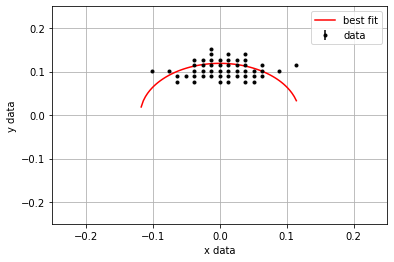

In [55]:
# perform fitting
pars0 = (np.max(triplet_x), np.max(triplet_x))

ind = (triplet_y > 0)

popt, pcov = curve_fit(felip, triplet_x[ind], triplet_y[ind], absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
b_opt = popt[1]

# plot data
plt.errorbar(triplet_x[ind], triplet_y[ind], yerr=0, fmt=".", color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-0.2, max( triplet_x), 100)
y_fit = felip(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")


plt.grid(True)
plt.xlabel("x data")
plt.ylabel("y data")


plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.legend();